In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
%matplotlib inline

# Dataset Online Retail

Este archivo reune todas las transacciones de un e-commerce británico dedicado a artículos de regalo y decoración durante un año.

In [3]:
df = pd.read_excel("Online Retail.xlsx")

Vamos a comenzar a dar una primera mirada sobre que contiene el dataset

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


A continuación vamos a ver los tipos de datos de las features y sus cantidades

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Como podemos observar la mayoría tiene el mismo valor de 541909 menos Description y CustomerID. 
Prosigamos...

Ahora veamos la cantidad de filas y columnas del dataset

In [6]:
print("Número de filas: ", df.shape[0])
print("Número de columnas: ", df.shape[1])

Número de filas:  541909
Número de columnas:  8


In [7]:
print("Número de IDs únicos:", len(df['CustomerID'].unique().tolist()))

Número de IDs únicos: 4373


A partir de las estadísticas descriptivas de las variables cuantitativas (cantidad y precio unitario), observamos que contienen valores negativos, que no son valores posibles para el precio y la cantidad.

In [8]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


Analicemos con más detalle el motivo de los valores negativos en estas variables. En la descripción del conjunto de datos se indica que se presentan algunas transacciones canceladas. Las transacciones canceladas se indican mediante un número de factura que empieza por la letra "c". Es probable que las transacciones con valores negativos de cantidad se cancelen.

Filtrando transacciones con un número de factura que empieza por la letra "C":

In [9]:
cancelados = df[df['InvoiceNo'].astype(str).str.contains('C')]
cancelados.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Entre las transacciones canceladas no hay ninguna transacción con cantidad positiva

In [10]:
cancelados[cancelados['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Sin embargo, algunas transacciones con cantidad negativa no pertenecen a canceladas:

In [11]:
print("Numero de transacciones canceladas:", len(cancelados))
print("Numero total de transacciones con cantidad negativa:", df[df['Quantity'] <= 0 ]['Quantity'].count())

Numero de transacciones canceladas: 9288
Numero total de transacciones con cantidad negativa: 10624


También existen transacciones con precio cero. Estas transacciones no aportan información útil para el análisis; además, generalmente carecen de descripción. Estas transacciones se van a eliminar.

In [12]:
df[df['UnitPrice'] == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


También hay dos transacciones con precio negativo. Según la descripción, estas transacciones probablemente se realizaron como corrección, por lo que también deberían eliminarse.

In [13]:
df[df['UnitPrice'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Como se mencionó anteriormente, hay algunas transacciones de cantidad negativa que no se cancelan, sin embargo, todas estas transacciones tienen precio 0.

In [14]:
d = df[~df['InvoiceNo'].astype(str).str.contains('C')]  
print("Número de transacciones con valor de cantidad negativo entre las transacciones no canceladas:" ,len(d[d['Quantity']<=0]))
print("Número de transacciones con precio cero y cantidad negativa:" ,len(d[(d['Quantity']<=0) & (d['UnitPrice'] == 0)]))

Número de transacciones con valor de cantidad negativo entre las transacciones no canceladas: 1336
Número de transacciones con precio cero y cantidad negativa: 1336


Porcentaje de transacciones que se eliminarán:

In [15]:
print("Porcentaje de transacciones canceladas:" , round(len(cancelados)/len(df)*100, 2),"%")
print("Porcentaje de transacciones con precio negativo o cero:" ,round(len(df[df['UnitPrice']<=0])/len(df)*100, 2),"%")

Porcentaje de transacciones canceladas: 1.71 %
Porcentaje de transacciones con precio negativo o cero: 0.46 %


In [62]:
df["InvoiceNo"].str.replace("[0-9]", "", regex=True).unique()

array([nan, 'C', 'A'], dtype=object)

Como se observa, hay tres tipos de codigos para los numeros de factura, sabemos que los que empiezan con C son cancelados, los nan son los normales, pero... los que arrancan con A?

In [65]:
df_con_A = df[df["InvoiceNo"].str.startswith("A").fillna(False)]
df_con_A.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Sigamos viendo, ahora el codigo de stock qué nos dice

In [66]:
df["StockCode"] = df["StockCode"].astype("str")
df[(df["StockCode"].str.match("^\\d{5}$") == False) & (df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]["StockCode"].unique()

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

### Notas sobre **StockCode**

El campo `StockCode` **debería** identificar un producto físico con un código numérico de 5 dígitos  
(ej.: `85123`). Sin embargo, la base trae varios valores “especiales” que NO representan
productos sino cargos administrativos, descuentos o ajustes.  
Para evitar que ensucien las métricas RFM (sobre todo *Monetary*), conviene filtrarlos
antes del clustering.

| Código               | Qué significa, en criollo                                                                                     | ¿Lo usamos en el clustering? | Motivo |
|----------------------|----------------------------------------------------------------------------------------------------------------|------------------------------|--------|
| `POST` / `DOT`       | Gastos de correo / flete que la empresa le pasa al cliente.                                                    | **Excluir** | No es compra real. |
| `D`                  | Descuento global aplicado a la factura.                                                                       | **Excluir** | Valor negativo, no es ítem. |
| `C2`                 | “Carriage” (otro tipo de cargo de transporte).                                                                | **Excluir** | Sin unidades físicas. |
| `M` o `m`            | Movimiento manual cargado por un admin (ajuste contable).                                                     | **Excluir** | No refleja comportamiento de compra. |
| `BANK CHARGES` / `B` | Comisiones bancarias repercutidas al cliente.                                                                  | **Excluir** | Gasto financiero. |
| `S`                  | Muestras gratuitas enviadas al cliente.                                                                       | **Excluir** | No hay pago asociado. |
| `AMAZONFEE`          | Comisión cobrada por ventas despachadas a través de Amazon.                                                   | **Excluir** | Gasto logístico. |
| `DCGSXXXX`           | “Discount Gift Set”: kits promocionales; muchos vienen con cantidad negativa y sin `CustomerID`.              | **Excluir** | Datos incompletos y valores atípicos. |
| `gift_0001_10/20…`   | Ítems pagados con gift-card; no traen datos de cliente y alteran el gasto.                                     | **Excluir** | No aportan al análisis de lealtad. |
| `CRUK`               | Donación a la organización “Cancer Research UK” incluida en el ticket.                                        | **Excluir** | Donación, no producto. |
| `PADS`               | Material de embalaje real (padding).                                                                          | **Incluir**  | Producto físico con venta legítima. |

> **Observación:** Nos quedamos sólo con los `StockCode` que representen **productos físicos vendidos**.
> Los otros códigos distorsionan el gasto total y la frecuencia sin aportar
> información sobre el comportamiento de compra del cliente.

Conservamos el código PADS porque corresponde a un artículo físico —material de embalaje o «padding»— que el cliente efectivamente paga: aparece con cantidades positivas, precio unitario y siempre asociado a un CustomerID. No es un cargo administrativo ni un ajuste contable; forma parte de la cesta de compra real. Excluirlo restaría ventas legítimas al cálculo de Monetary y disminuiría la Frequency, subestimando el verdadero valor y hábito de compra del cliente.


In [67]:
df[df["StockCode"].str.contains("^DOT")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,NaN,United Kingdom
3041,536592,DOT,DOTCOM POSTAGE,1,2010-12-01 17:06:00,607.49,NaN,United Kingdom
5450,536862,DOT,DOTCOM POSTAGE,1,2010-12-03 11:13:00,254.43,NaN,United Kingdom
5545,536864,DOT,DOTCOM POSTAGE,1,2010-12-03 11:27:00,121.06,NaN,United Kingdom
5685,536865,DOT,DOTCOM POSTAGE,1,2010-12-03 11:28:00,498.47,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
536834,581219,DOT,DOTCOM POSTAGE,1,2011-12-08 09:28:00,1008.96,NaN,United Kingdom
537254,581238,DOT,DOTCOM POSTAGE,1,2011-12-08 10:53:00,1683.75,NaN,United Kingdom
539368,581439,DOT,DOTCOM POSTAGE,1,2011-12-08 16:30:00,938.59,NaN,United Kingdom
540908,581492,DOT,DOTCOM POSTAGE,1,2011-12-09 10:03:00,933.17,NaN,United Kingdom


In [68]:
df_pads=df[df["StockCode"].str.contains("^PADS")]
df_pads.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15 09:27:00,0.001,13952.0,United Kingdom
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-07-26 10:13:00,0.001,15618.0,United Kingdom
358655,568158,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 12:22:00,0.000,16133.0,United Kingdom
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 14:58:00,0.001,16198.0,United Kingdom


# Data cleaning

In [69]:
cleaned_df = df.copy()

In [70]:
cleaned_df["InvoiceNo"] = cleaned_df["InvoiceNo"].astype("str")

mask = (
    cleaned_df["InvoiceNo"].str.match("^\\d{6}$") == True
)

cleaned_df = cleaned_df[mask]

cleaned_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [71]:
cleaned_df["StockCode"] = cleaned_df["StockCode"].astype("str")

mask = (
    (cleaned_df["StockCode"].str.match("^\\d{5}$") == True)
    | (cleaned_df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == True)
    | (cleaned_df["StockCode"].str.match("^PADS$") == True)
)

cleaned_df = cleaned_df[mask]

cleaned_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


Se observan todavía más letras para los códigos del stock, las cuales vamos a omitir en el estudio pero las tendremos en cuenta para el análisis RFM ya que no hay comportamientos extraños en dichos datos

In [72]:
cleaned_df[(cleaned_df['UnitPrice'] > 0) & (cleaned_df['Quantity']>0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


Todas las filas con descripciones faltantes desaparecen después de eliminar las transacciones problemáticas. Nos vamos a quedar con las filas que tengan precio unitario y cantidades positivas ya que serán relevantes para nuestro análisis.



In [73]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530214 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530214 non-null  object        
 1   StockCode    530214 non-null  object        
 2   Description  528775 non-null  object        
 3   Quantity     530214 non-null  int64         
 4   InvoiceDate  530214 non-null  datetime64[ns]
 5   UnitPrice    530214 non-null  float64       
 6   CustomerID   396374 non-null  float64       
 7   Country      530214 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


Veamos ahora si hay transacciones duplicadas

In [74]:
print("Numero de transacciones duplicadas:", len(cleaned_df[cleaned_df.duplicated()]))

Numero de transacciones duplicadas: 5226


In [75]:
cleaned_df.drop_duplicates(inplace = True)
print("Numero de transacciones duplicadas:", len(cleaned_df[cleaned_df.duplicated()]))

Numero de transacciones duplicadas: 0


ahora veamos si hay valores de id de clientes faltantes

In [76]:
print("Ids de clientes faltantes:", cleaned_df[cleaned_df['CustomerID'].isnull()]['CustomerID'].count())

Ids de clientes faltantes: 0


Luego podemos observar que hay clientes cuyo ID es NaN por lo que vamos a borrarlos

In [77]:
cleaned_df[cleaned_df['CustomerID'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541535,581498,85049e,SCANDINAVIAN REDS RIBBONS,4,2011-12-09 10:26:00,3.29,NaN,United Kingdom
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom


In [78]:

cleaned_df.dropna(subset=["CustomerID"], inplace=True)

In [79]:
cleaned_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,391187.000000,391187,391187.000000,391187.000000
mean,13.179541,2011-07-10 19:37:46.280525824,2.874101,15295.085345
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13969.000000
50%,6.000000,2011-07-31 12:05:00,1.950000,15158.000000
75%,12.000000,2011-10-20 12:57:00,3.750000,16794.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,181.906477,NaN,4.284627,1710.353395


In [86]:
min_price = cleaned_df["UnitPrice"].min()
print(f"{min_price:.5f}")

0.00000


In [93]:
cleaned_df=cleaned_df[cleaned_df['UnitPrice'] > 0]

In [103]:
cleaned_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,391153.000000,391153,391153.000000,391153.000000
mean,13.145207,2011-07-10 19:37:36.089765632,2.874350,15295.171156
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13969.000000
50%,6.000000,2011-07-31 12:05:00,1.950000,15159.000000
75%,12.000000,2011-10-20 12:57:00,3.750000,16794.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,180.807141,NaN,4.284729,1710.334509


In [104]:
min_price = cleaned_df["UnitPrice"].min()
print(f"{min_price:.3f}")

0.001


Se debe tener en cuenta que una misma descripción podría estar escrita en diferentes maneras con mayusculas o minusculas, vamos a escribir todas las descripciones a minúsculas.

In [105]:
# Creamos un DataFrame auxiliar con la columna original y su versión en minúsculas
desc_df = cleaned_df[['Description']].copy()
desc_df['Description_lower'] = desc_df['Description'].str.lower()

# Buscamos descripciones que, al pasar a minúsculas, tengan más de una forma distinta
duplicadas = (
    desc_df.groupby('Description_lower')
    .agg({'Description': lambda x: list(set(x))})  # Agrupamos por las variantes originales
    .reset_index()
)

# Filtramos solo las que tienen más de una forma distinta
duplicadas = duplicadas[duplicadas['Description'].apply(len) > 1]

# Mostramos el resultado
duplicadas.head(10)  # Muestra los primeros 10 casos, si los hay



,Description_lower,Description


Vamos a trabajarlas en minusculas

In [106]:
cleaned_df['Description'] = cleaned_df['Description'].str.lower()
print("Numero de descripciones unicas:", len(cleaned_df['Description'].unique().tolist()))

Numero de descripciones unicas: 3862


In [107]:
cleaned_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Vamos a eliminar puntuaciones al final de la descripcion

In [108]:
cleaned_df['Description'] = cleaned_df['Description'].replace(to_replace=r'[^\w\s]', value='', regex=True) 
print("Numero de descripciones unicas:", len(cleaned_df['Description'].unique().tolist()))

Numero de descripciones unicas: 3862


In [109]:
cleaned_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


El código de stock debe ser un valor numérico, sin embargo, hay algunas transacciones que contienen solo varias letras/palabras; estas transacciones también se descartarán.

In [101]:
# data = data.loc[data['StockCode'].astype(str).str[0:4].str.isdigit()]

Nos quedamos con filas cuyo stock tiene un código numérico de 5 digitos

In [102]:
# len(data['StockCode'].unique().tolist())

--------

# Feature Engineering

Con respecto a las fechas, añadiremos features como año, mes, mes del año, día de la semana y hora:

In [114]:
cleaned_df['month'] = cleaned_df['InvoiceDate'].dt.month
cleaned_df['year'] = cleaned_df['InvoiceDate'].dt.year
cleaned_df['WeekDay'] = cleaned_df['InvoiceDate'].dt.day_name()
cleaned_df['day'] = cleaned_df['InvoiceDate'].dt.day
cleaned_df['month_year'] = pd.to_datetime(cleaned_df[['year', 'month']].assign(Day=1))

cleaned_df['hour'] = cleaned_df['InvoiceDate'].dt.hour

In [115]:
cleaned_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,WeekDay,month_year,hour,day
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,1
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,1
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,1
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,1
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,1


Ahora vamos a añadir una nueva feature con el calculo de las ganancias

In [116]:
cleaned_df['revenue'] = cleaned_df['UnitPrice'] * cleaned_df['Quantity']

Veamos qué onda las ordenes de compra por mes

In [117]:
plot = pd.DataFrame(cleaned_df.groupby(['month_year'])['InvoiceNo'].count()).reset_index()
plot2 = pd.DataFrame(cleaned_df.groupby(['WeekDay'])['InvoiceNo'].count())
plot3 = pd.DataFrame(cleaned_df.groupby(['hour'])['InvoiceNo'].count()).reset_index()
plot4 = pd.DataFrame(cleaned_df.groupby(['month_year'])['revenue'].mean()).reset_index()
plot5 = pd.DataFrame(cleaned_df.groupby(['month_year'])['revenue'].sum()).reset_index()

In [118]:
plot2 = plot2.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']).reset_index()

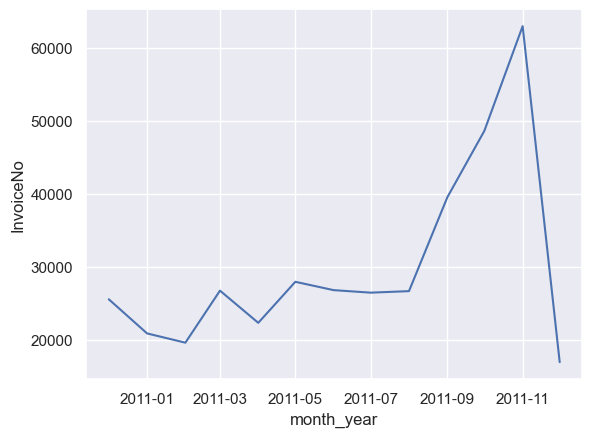

In [119]:
ax = sns.lineplot(x="month_year", y="InvoiceNo", data = plot)

Se realizan más compras a finales de año. El mayor número de transacciones se realizó en noviembre. Probablemente, la razón podría ser que la gente suele prepararse para la Navidad en noviembre. Aparte de noviembre, el número de compras durante el año es bastante similar.

Ahora veamos qué onda las compras por día, que día es el de mayor demanda

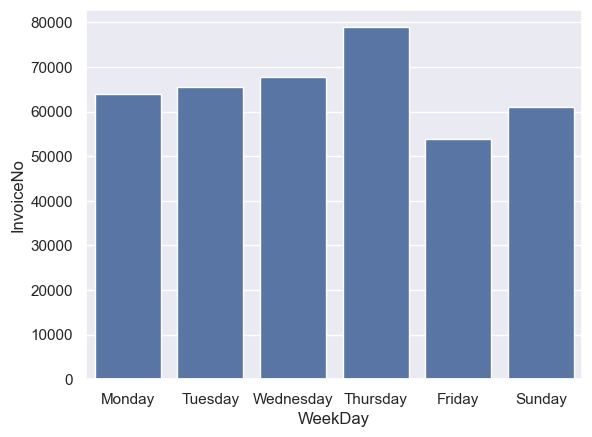

In [120]:
ax = sns.barplot(x="WeekDay", y="InvoiceNo", data = plot2)

Ninguna transacción se realizó el sabado??
 Una posible explicación podría ser algún filtro durante el proceso de recopilación de datos. El número de compras no varía significativamente según el día de la semana.

Veamos que onda las ordenes de compra por hora

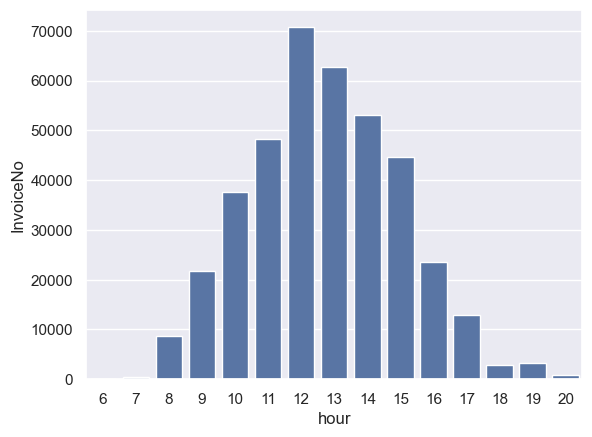

In [121]:
ax = sns.barplot(x="hour", y="InvoiceNo", data = plot3)

Por lo que vemos la mayor cantidad de compras se realizan de 12 a 14. Será que es más conveniente comprar durante esa hora? la menor cantidad de transacciones es entre las 20 y las 7 de la mañana que no se compra practicamente nada.

Veamos el mes en el que se vende más

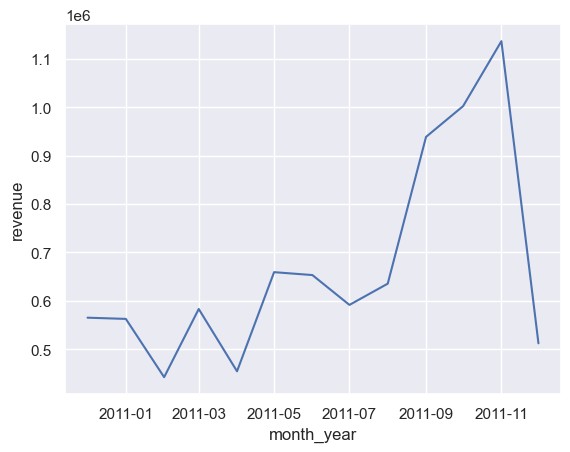

In [122]:
ax = sns.lineplot(x = 'month_year', y='revenue', data = plot5)

Las mayores ventas también se dan durante el mes de noviembre, ya que el número de compras es el más alto.

Ahora veamos qué tal se comporta el precio

In [123]:
pd.DataFrame(cleaned_df['UnitPrice'].describe())

,UnitPrice
count,391153.000000
mean,2.874350
std,4.284729
min,0.001000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


A partir de las estadísticas descriptivas de la variable precio, observamos que la mayoría de los productos vendidos son bastante económicos. Probablemente, el comercio minorista vende artículos pequeños, como material de oficina, pequeñas decoraciones, etc.

Descripción de productos que cuestan más de 50 (Supuesto: misma moneda para ventas minoristas en diferentes países).

In [124]:
cleaned_df[cleaned_df['UnitPrice']>50]['Description'].unique().tolist()

['rustic  seventeen drawer sideboard',
 'vintage post office cabinet',
 'vintage red kitchen cabinet',
 'regency mirror with shutters',
 'love seat antique white metal',
 'vintage blue kitchen cabinet',
 'school desk and chair ',
 'chest natural wood 20 drawers',
 'decorative hanging shelving unit',
 'picnic basket wicker 60 pieces']

Distribución de precios de bienes caros:

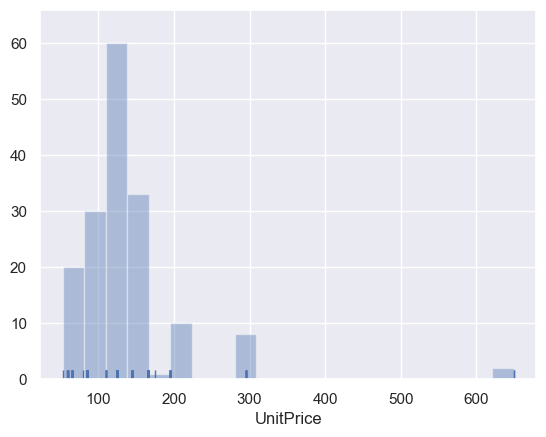

In [ ]:
sns.distplot(cleaned_df[cleaned_df['UnitPrice']>50]['UnitPrice'], kde=False, rug=True);

Ahora veamos qué tal las transacciones por pais

In [125]:
customer_country=cleaned_df[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Country,CustomerID
35,United Kingdom,3916
14,Germany,94
13,France,87
30,Spain,30
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,14
12,Finland,12
1,Austria,11


Como la mayoría son de reino unido, me conviene centrar mi estudio en dicho pais.

Veamos cuantos paises son en total

In [126]:
print("Las transacciones fueron hechas en", len(cleaned_df['Country'].unique().tolist()), "paises diferentes")

Las transacciones fueron hechas en 37 paises diferentes


In [127]:
print("El numero de transacciones donde el pais es indefinido es:", len(cleaned_df[cleaned_df['Country']=='Unspecified']))

El numero de transacciones donde el pais es indefinido es: 241


In [128]:
plot6 = pd.DataFrame(cleaned_df.groupby(['Country'])['revenue'].sum()).reset_index()
plot6 = plot6.sort_values(['revenue']).reset_index(drop=True)
plot7 = pd.DataFrame(cleaned_df.groupby(['Country'])['revenue'].count()).reset_index()
plot7 = plot7.sort_values(['revenue']).reset_index(drop=True)

## Cantidades de ventas, ganó UK por mucho

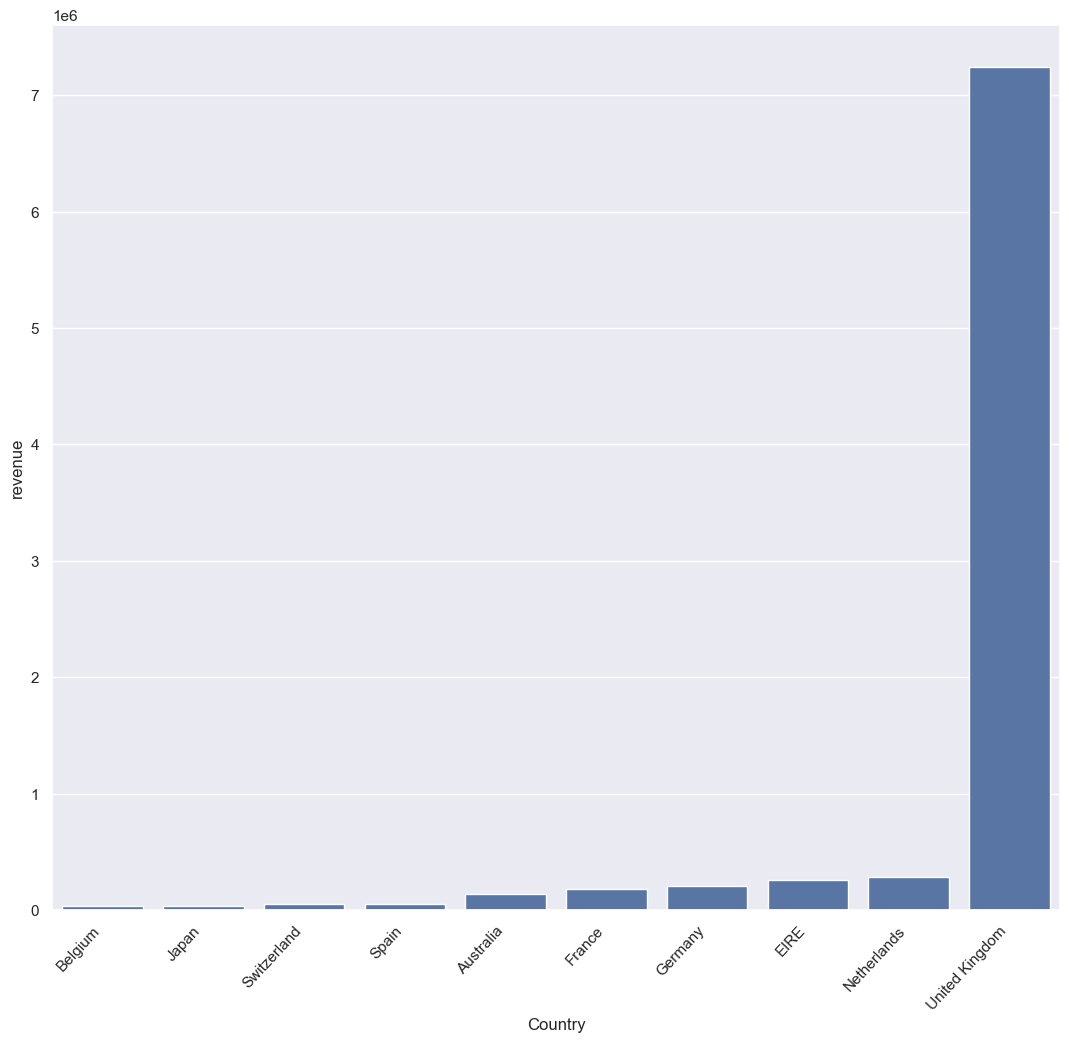

In [129]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='Country', y='revenue',data=plot6.tail(10),estimator=max,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()

## Cantidad de compras, la otra cara de la moneda

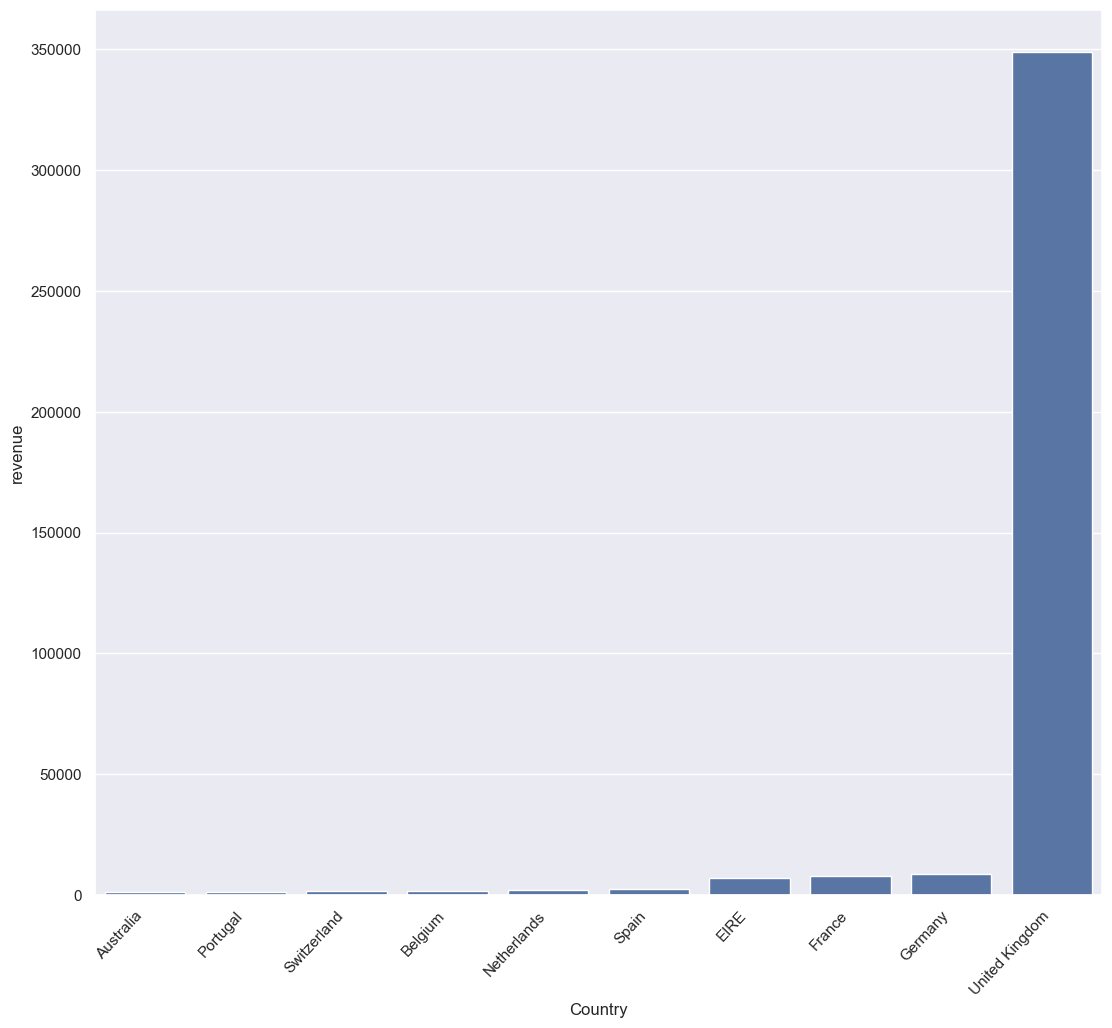

In [130]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='Country', y='revenue',data=plot7.tail(10),estimator=max,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()

vamos a considerar finalmente a uk para nuestro analisis RFM

In [131]:
df_uk = cleaned_df[cleaned_df['Country'] == "United Kingdom"]
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,WeekDay,month_year,hour,day,revenue
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,1,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,1,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,1,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,1,20.34
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,Wednesday,2010-12-01,8,1,20.34


Hagamos un top de clientes sobre la frecuencia de compras durante 1 año

In [132]:
df_uk['freq'] = df_uk.groupby('CustomerID')['CustomerID'].transform('count')

Ahora vamos a calcular los 500 clientes principales que generan los mayores ingresos

In [133]:
customer  = pd.DataFrame(df_uk.groupby(['CustomerID'])['revenue'].sum().sort_values(ascending=False)).reset_index().head(10)

In [134]:
customer['CustomerID'].tolist()

[18102.0,
 17450.0,
 16446.0,
 17511.0,
 12346.0,
 16029.0,
 16684.0,
 13694.0,
 15311.0,
 13089.0]

Veamos en UK que onda las fechas de las facturas, cual fue la primera y la mas reciente

In [135]:
print(df_uk['InvoiceDate'].min())
print(df_uk['InvoiceDate'].max())

2010-12-01 08:26:00
2011-12-09 12:49:00


En este bloque importamos datetime, definimos el 10/12/2011 como fecha de corte (snapshot)—o sea, el “hoy” contra el que mediremos cuántos días pasaron desde la última compra de cada cliente—y transformamos InvoiceDate a un tipo fecha nativo en pandas para poder restarla y agrupar sin dramas.

In [136]:
import datetime as dt
presence = dt.datetime(2011,12,10)
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])

Calcular la actualidad, la frecuencia y los valores monetarios:

Actualidad (R) como días desde la última compra: ¿Cuántos días hace de su última compra? Reste la fecha de compra más reciente de hoy para calcular el valor de actualidad. ¿Hace 1 día? ¿Hace 14 días? ¿Hace 500 días?

Frecuencia (F) como número total de transacciones: ¿Cuántas veces ha comprado el cliente en nuestra tienda? Por ejemplo, si alguien realizó 10 pedidos en un período de tiempo, su frecuencia es 10.

Monetario (M) como dinero total gastado: ¿Cuánto $$ (o la moneda que utilice para calcularlo) ha gastado este cliente? Nuevamente, limite el gasto a los últimos dos años o tome todo el tiempo. Simplemente sume el dinero de todas las transacciones para obtener el valor M.

Antes de continuar me gustaria revisar si hay mas valores atípicos

In [137]:
# --- Celda: Detección de registros imposibles --------------------------------
# Parámetros razonables para este negocio de regalos
MAX_UNITPRICE = 1_000        # £1000: nada cuesta más que eso
MAX_QUANTITY  = 5_000        # 5 000 u: tope lógico de un pedido
DATE_MIN, DATE_MAX = '2010-12-01', '2011-12-09'

# Aseguramos que total_price esté actualizado
df_uk['total_price'] = df_uk['Quantity'] * df_uk['UnitPrice']

# Construimos la máscara de casos imposibles
mask_imposible = (
    (df_uk['UnitPrice']  > MAX_UNITPRICE) |                  # precio unitario ridículo
    (df_uk['Quantity']   > MAX_QUANTITY)  |                  # cantidad absurda
    (df_uk['total_price'] < df_uk['UnitPrice']) |            # total incoherente
   # (~df_uk['InvoiceDate'].between(DATE_MIN, DATE_MAX)) |    # fecha fuera de rango
    (df_uk['CustomerID'].isna()) |                           # sin CustomerID
    (df_uk['StockCode'].astype(str).str.len() > 10)          # código raro
)

# Extraemos los sospechosos para inspección
df_imposible = df_uk.loc[mask_imposible]

print(f"Registros potencialmente imposibles: {df_imposible.shape[0]}")
display(df_imposible.head(40))



Registros potencialmente imposibles: 2


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,WeekDay,month_year,hour,day,revenue,freq,total_price
61619,541431,23166,medium ceramic top storage jar,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,1,2011,Tuesday,2011-01-01,10,18,77183.6,1,77183.6
540421,581483,23843,paper craft little birdie,80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,12,2011,Friday,2011-12-01,9,9,168469.6,3,168469.6


Estas dos compras se ven bastante sospechosas, en primera instancia las vamos a descartar ya que creemos que es poco probable que se compre tales cantidades de dichos productos por más que sea una compra mayorista.

In [138]:
df_uk = df_uk[~mask_imposible]
df_uk.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,month,year,month_year,hour,day,revenue,freq,total_price
count,348873.000000,348873,348873.000000,348873.000000,348873.000000,348873.000000,348873,348873.000000,348873.000000,348873.000000,348873.000000,348873.000000
mean,11.692235,2011-07-11 03:30:31.105244160,2.864341,15548.448410,7.634990,2010.932847,2011-06-26 13:31:10.813734400,12.803361,15.028363,20.056588,602.116664,20.056588
min,1.000000,2010-12-01 08:26:00,0.001000,12747.000000,1.000000,2010.000000,2010-12-01 00:00:00,6.000000,1.000000,0.001000,1.000000,0.001000
25%,2.000000,2011-04-07 11:47:00,1.250000,14191.000000,5.000000,2011.000000,2011-04-01 00:00:00,11.000000,7.000000,4.200000,87.000000,4.200000
50%,4.000000,2011-07-31 13:37:00,1.950000,15518.000000,9.000000,2011.000000,2011-07-01 00:00:00,13.000000,15.000000,10.200000,195.000000,10.200000
75%,12.000000,2011-10-23 11:10:00,3.750000,16931.000000,11.000000,2011.000000,2011-10-01 00:00:00,14.000000,22.000000,17.850000,432.000000,17.850000
max,4800.000000,2011-12-09 12:49:00,649.500000,18287.000000,12.000000,2011.000000,2011-12-01 00:00:00,20.000000,31.000000,38970.000000,7667.000000,38970.000000
std,42.150512,NaN,4.341397,1594.290191,3.416524,0.250288,NaN,2.246195,8.684910,96.199723,1347.445176,96.199723


Luego nos ponemos a ver los clientes que compran en cantidad y compran productos más caros, considerando que no son outliers

In [56]:
df_uk.sort_values(by='Quantity', ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,WeekDay,month_year,hour,revenue,freq,total_price
421632,573008,84077,world war 2 gliders asstd designs,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom,10,2011,Thursday,2011-10-01,12,1008.00,116,1008.00
206121,554868,22197,small popcorn holder,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom,5,2011,Friday,2011-05-01,10,3096.00,1,3096.00
97432,544612,22053,empire design rosette,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom,2,2011,Tuesday,2011-02-01,10,3202.92,1,3202.92
270885,560599,18007,essential balm 35g tin in envelope,3186,2011-07-19 17:04:00,0.06,14609.0,United Kingdom,7,2011,Tuesday,2011-07-01,17,191.16,4,191.16
160546,550461,21108,fairy cake flannel assorted colour,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,4,2011,Monday,2011-04-01,13,6539.40,10,6539.40


In [139]:
df_uk.sort_values(by='total_price', ascending=False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,WeekDay,month_year,hour,day,revenue,freq,total_price
222680,556444,22502,picnic basket wicker 60 pieces,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,6,2011,Friday,2011-06-01,15,10,38970.00,3,38970.00
348325,567423,23243,set of tea coffee sugar tins pantry,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,9,2011,Tuesday,2011-09-01,11,20,7144.72,336,7144.72
52711,540815,21108,fairy cake flannel assorted colour,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,1,2011,Tuesday,2011-01-01,12,11,6539.40,10,6539.40
160546,550461,21108,fairy cake flannel assorted colour,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom,4,2011,Monday,2011-04-01,13,18,6539.40,10,6539.40
52709,540815,85123A,white hanging heart tlight holder,1930,2011-01-11 12:55:00,2.55,15749.0,United Kingdom,1,2011,Tuesday,2011-01-01,12,11,4921.50,10,4921.50
160542,550461,85123A,white hanging heart tlight holder,1930,2011-04-18 13:20:00,2.40,15749.0,United Kingdom,4,2011,Monday,2011-04-01,13,18,4632.00,10,4632.00
52772,540818,48185,doormat fairy cake,670,2011-01-11 12:57:00,6.75,15749.0,United Kingdom,1,2011,Tuesday,2011-01-01,12,11,4522.50,10,4522.50
244419,558526,23173,regency teapot roses,540,2011-06-30 11:01:00,8.15,17949.0,United Kingdom,6,2011,Thursday,2011-06-01,11,30,4401.00,69,4401.00
160544,550461,48185,doormat fairy cake,670,2011-04-18 13:20:00,6.35,15749.0,United Kingdom,4,2011,Monday,2011-04-01,13,18,4254.50,10,4254.50
291249,562439,84879,assorted colour bird ornament,2880,2011-08-04 18:06:00,1.45,12931.0,United Kingdom,8,2011,Thursday,2011-08-01,18,4,4176.00,82,4176.00


# Análisis RFM

In [ ]:
# ---------------------------------------------------------------
# 1. Construir tabla RFM a partir de df_uk
# ---------------------------------------------------------------
rfm = (
    df_uk.groupby("CustomerID")
         .agg(
             Recency   = ("InvoiceDate", lambda x: (presence - x.max()).days),
             Frequency = ("InvoiceNo",   "nunique"),
             Monetary  = ("total_price", "sum")
         )
         .reset_index()
)

print("🔹 Primeras filas de la tabla RFM")
display(rfm.head())

🔹 Primeras filas de la tabla RFM


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,11,4196.01
2,12748.0,0,206,31650.78
3,12749.0,3,5,4040.88
4,12820.0,3,4,942.34


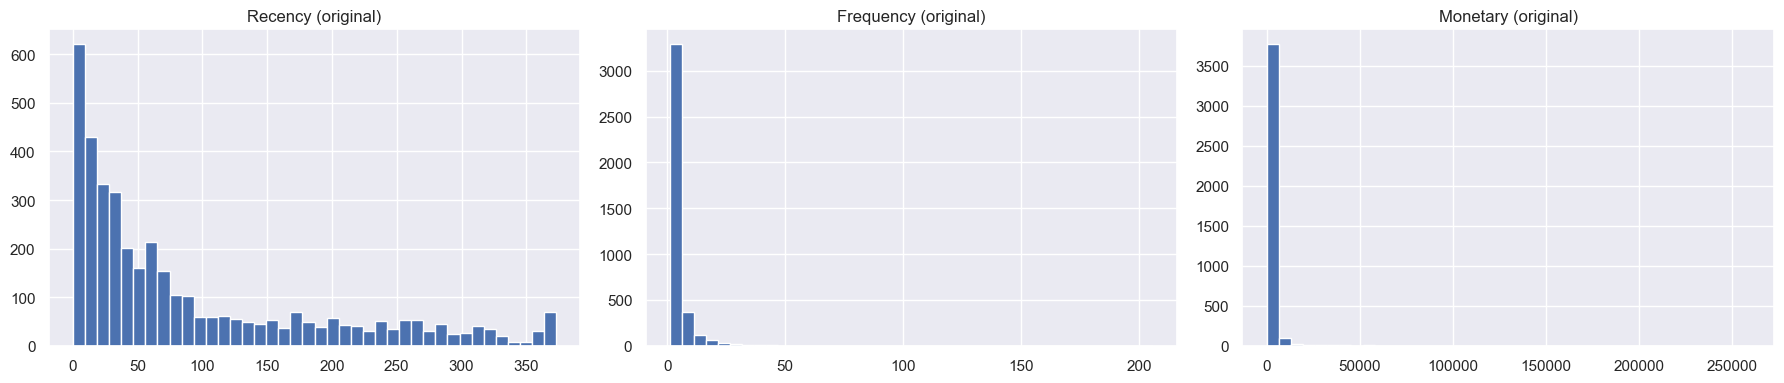

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
for axi, col in zip(ax, ["Recency", "Frequency", "Monetary"]):
    axi.hist(rfm[col], bins=40)
    axi.set_title(f"{col} (original)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
rfm_scaled_values = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])
rfm_scaled = pd.DataFrame(
    rfm_scaled_values,
    columns=["Recency_scaled", "Frequency_scaled", "Monetary_scaled"],
    index=rfm.index
)

# Guardamos la versión escalada para la Parte 2
rfm_final = pd.concat([rfm, rfm_scaled], axis=1)

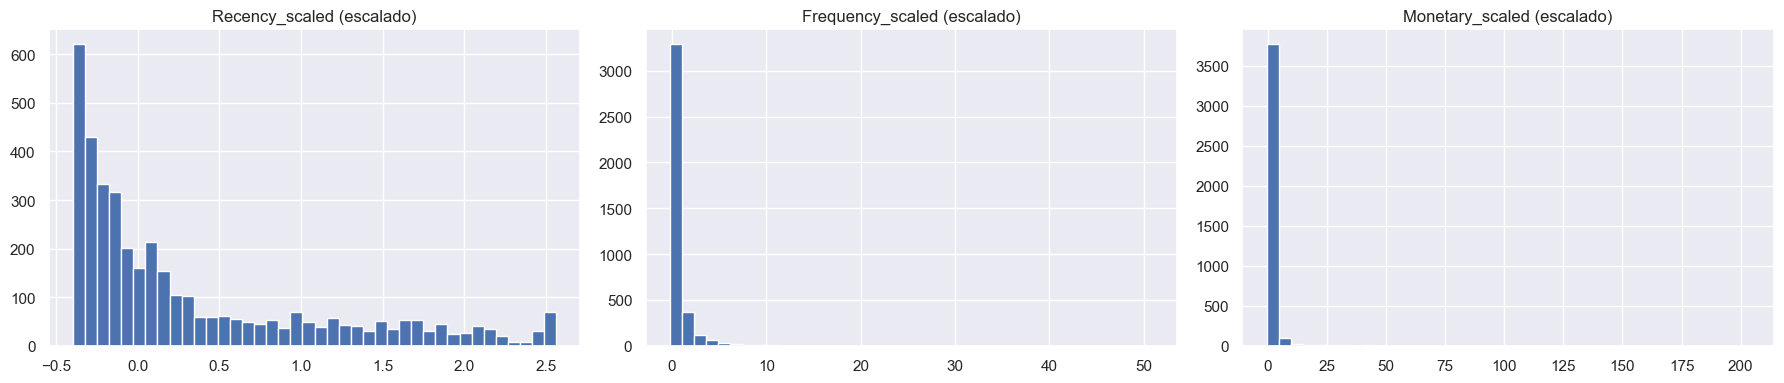

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
for axi, col in zip(ax, ["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]):
    axi.hist(rfm_final[col], bins=40)
    axi.set_title(f"{col} (escalado)")
plt.tight_layout()
plt.show()

In [ ]:
print("\n🔹 Dimensión tabla RFM final:", rfm_final.shape)
print("   Columnas disponibles:", list(rfm_final.columns))


🔹 Dimensión tabla RFM final: (3916, 7)
   Columnas disponibles: ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']


# PARTE 2

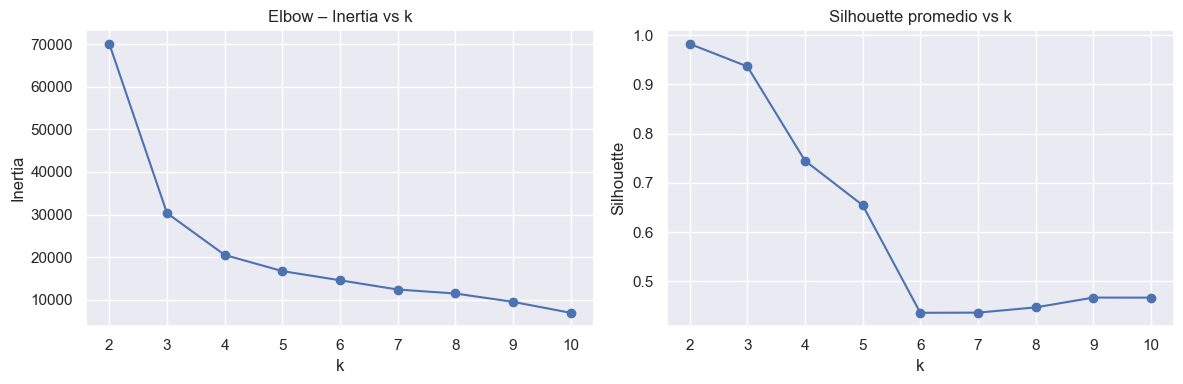

↳ k óptimo elegido para K-Means: 2


In [ ]:
# ================================================================
#   PARTE 2 – APLICACIÓN DE CLUSTERING
#   Requisitos:
#     ▸ Usar ≥3 algoritmos (K-Means, Agglomerative, DBSCAN)
#     ▸ Seleccionar nº de clusters / hiperparámetros con métricas
#     ▸ Comparar resultados con Silhouette, Calinski-Harabasz,
#       Davies-Bouldin
# ================================================================

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # si no lo tenés: pip install seaborn

# ---------------------------------------------------------------
# Prepara matriz de características
# ---------------------------------------------------------------
features = rfm_final[["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]].values

# Función auxiliar para evaluar un modelo de clustering
def evaluate_clustering(X, labels, algo_name=""):
    """Devuelve dict con Silhouette, Calinski-Harabasz y Davies-Bouldin."""
    # Evitar métricas si se produce un único cluster
    if len(set(labels)) < 2 or (set(labels) == {-1}):
        return {"Algoritmo": algo_name, "Clusters": len(set(labels)), 
                "Silhouette": np.nan, "Calinski": np.nan, "Davies": np.nan}
    return {
        "Algoritmo": algo_name,
        "Clusters": len(set(labels)),
        "Silhouette": silhouette_score(X, labels),
        "Calinski": calinski_harabasz_score(X, labels),
        "Davies": davies_bouldin_score(X, labels),
    }

# ---------------------------------------------------------------
# 1. K-Means — Búsqueda de k óptimo (Elbow + Silhouette)
# ---------------------------------------------------------------
inertias, silhouettes = [], []
K_RANGE = range(2, 11)

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(features)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(features, kmeans.labels_))

# Gráfica Elbow + Silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(K_RANGE, inertias, marker="o")
ax[0].set_title("Elbow – Inertia vs k")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

ax[1].plot(K_RANGE, silhouettes, marker="o")
ax[1].set_title("Silhouette promedio vs k")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette")

plt.tight_layout(); plt.show()

# Elegimos el k con mejor trade-off (máx. silhouette ≈ codo)
best_k = int(np.argmax(silhouettes) + 2)
print(f"↳ k óptimo elegido para K-Means: {best_k}")

kmeans_model = KMeans(n_clusters=best_k, random_state=42, n_init="auto").fit(features)
eval_kmeans = evaluate_clustering(features, kmeans_model.labels_, "K-Means")

In [ ]:
# ---------------------------------------------------------------
# 2. Agglomerative Clustering (ward linkage) – mismo k
# ---------------------------------------------------------------
agg_model = AgglomerativeClustering(n_clusters=best_k, linkage="ward").fit(features)
eval_agg = evaluate_clustering(features, agg_model.labels_, "Agglomerative")

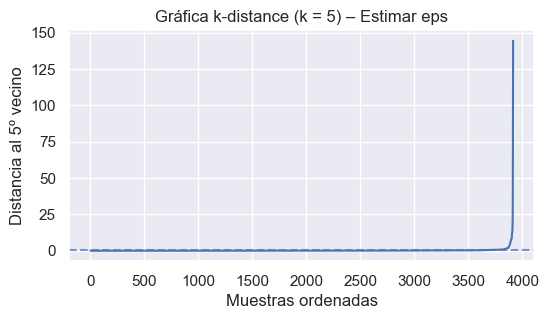

↳ eps óptimo elegido para DBSCAN: 1.1


In [ ]:
# ---------------------------------------------------------------
# 3. DBSCAN — Elección sistemática de eps con k-distance
# ---------------------------------------------------------------
# 3.1 k-distance plot (k = min_samples = 5)
from sklearn.neighbors import NearestNeighbors
k_dist = 5
nbrs = NearestNeighbors(n_neighbors=k_dist).fit(features)
distances, _ = nbrs.kneighbors(features)
k_distances = np.sort(distances[:, -1])  # distancia al 5º vecino

plt.figure(figsize=(6, 3))
plt.plot(k_distances)
plt.title("Gráfica k-distance (k = 5) – Estimar eps")
plt.xlabel("Muestras ordenadas"); plt.ylabel("Distancia al 5º vecino")
plt.axhline(k_distances[int(0.95 * len(k_distances))], ls="--", alpha=0.7)
plt.show()

# 3.2 Prueba de varios eps alrededor del codo visual
EPS_VALUES = np.round(np.linspace(0.3, 1.2, 10), 2)  # ajusta si tu escala es distinta
dbscan_results = []

for eps in EPS_VALUES:
    db_model = DBSCAN(eps=eps, min_samples=k_dist).fit(features)
    labels = db_model.labels_
    metrics = evaluate_clustering(features, labels, f"DBSCAN eps={eps}")
    dbscan_results.append(metrics)

# Elegimos mejor eps (mayor silhouette válido)
dbscan_df = pd.DataFrame(dbscan_results).dropna()
best_eps = (
    dbscan_df.loc[dbscan_df["Silhouette"].idxmax(), "Algoritmo"]
    .split("eps=")[1]
)
best_eps = float(best_eps)

print(f"↳ eps óptimo elegido para DBSCAN: {best_eps}")

dbscan_model = DBSCAN(eps=best_eps, min_samples=k_dist).fit(features)
eval_dbscan = evaluate_clustering(features, dbscan_model.labels_, "DBSCAN")

In [ ]:
# ---------------------------------------------------------------
# 4. Comparación de métricas internas
# ---------------------------------------------------------------
metrics_table = pd.DataFrame([eval_kmeans, eval_agg, eval_dbscan])
display(metrics_table.style.format({"Silhouette": "{:.3f}",
                                    "Calinski":   "{:.1f}",
                                    "Davies":     "{:.3f}"}))

,Algoritmo,Clusters,Silhouette,Calinski,Davies
0,K-Means,2,0.982,4402.2,0.184
1,Agglomerative,2,0.982,4402.2,0.184
2,DBSCAN,2,0.916,2385.3,0.810


In [ ]:
# ---------------------------------------------------------------
# 5. Selección del mejor modelo (basado en Silhouette > 0 & calinski alto & davies bajo)
# ---------------------------------------------------------------
best_algo = metrics_table.sort_values(
    by=["Silhouette", "Calinski", "Davies"],
    ascending=[False, False, True]
).iloc[0]["Algoritmo"]

print(f"🏆 Modelo recomendado para Parte 3: {best_algo}")

🏆 Modelo recomendado para Parte 3: K-Means


# Parte 3

In [ ]:
# ================================================================
#   PARTE 3 – ANÁLISIS E INTERPRETACIÓN DE CLUSTERS
# ================================================================
# Objetivos:
#   ▸ Añadir etiquetas de cluster al dataframe RFM
#   ▸ Perfilado estadístico por grupo
#   ▸ Visualización 2-D con PCA
#   ▸ (En comentarios ▶) Acciones de marketing + limitaciones
# ================================================================

# ---------------------------------------------------------------
# 1. Añadir la etiqueta del cluster “mejor” al rfm_final
# ---------------------------------------------------------------
if best_algo.startswith("K-Means"):
    cluster_labels = kmeans_model.labels_
elif best_algo.startswith("Agglomerative"):
    cluster_labels = agg_model.labels_
else:  # DBSCAN
    cluster_labels = dbscan_model.labels_

rfm_final["Cluster"] = cluster_labels

# Para DBSCAN, re-etiquetar ruido (-1) como 99 para evitar confusión
rfm_final["Cluster"] = rfm_final["Cluster"].replace(-1, 99)

print("🔹 Distribución de clientes por cluster")
display(rfm_final["Cluster"].value_counts().sort_index())


🔹 Distribución de clientes por cluster


Cluster
0    3913
1       3
Name: count, dtype: int64

In [ ]:
# ---------------------------------------------------------------
# 2. Perfilado estadístico básico (tamaño + medias R, F, M)
# ---------------------------------------------------------------
cluster_profile = (
    rfm_final
      .groupby("Cluster")
      .agg(
          CantClientes = ("CustomerID", "nunique"),
          Recency_avg  = ("Recency",    "mean"),
          Frequency_avg= ("Frequency",  "mean"),
          Monetary_avg = ("Monetary",   "mean")
      )
      .sort_values("Monetary_avg", ascending=False)
)

print("🔹 Perfil de clusters (ordenado por gasto medio)")
display(cluster_profile.style.format({"Recency_avg":"{:.1f}",
                                      "Frequency_avg":"{:.2f}",
                                      "Monetary_avg":"{:.2f}"}))

🔹 Perfil de clusters (ordenado por gasto medio)


,CantClientes,Recency_avg,Frequency_avg,Monetary_avg
Cluster,,,,
1,3,2.7,36.00,207506.86
0,3913,92.0,4.21,1691.88


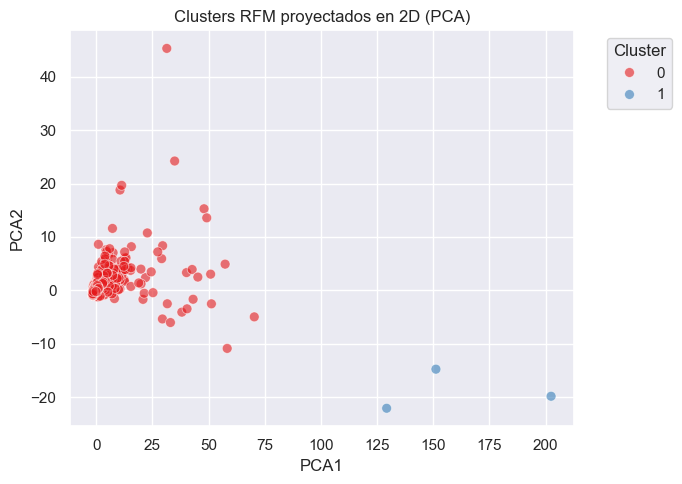

In [ ]:
# ---------------------------------------------------------------
# 3. Visualización 2-D con PCA
# ---------------------------------------------------------------
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(features)

rfm_final["PCA1"] = pca_coords[:, 0]
rfm_final["PCA2"] = pca_coords[:, 1]

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=rfm_final, x="PCA1", y="PCA2",
    hue="Cluster", palette="Set1", alpha=0.6, s=50
)
plt.title("Clusters RFM proyectados en 2D (PCA)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()